# 1-3. Categorize job titles using unsupervised learning approach 

Job posting data is provided by: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

Author: Yu Kyung Koh

Last Updated: 2025/06/01

In this code, I apply unsupervised learning methods (e.g., k-means clustering and LDA) to classify jobs.

Unlike the code 1-2, I bring in ALL job postings, not just the ones for the selected white-collar jobs. 

In [2]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import LabelEncoder
import gensim
from gensim import corpora
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yukyungkoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yukyungkoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#from nltk.tokenize import word_tokenize
#word_tokenize("This is a test.")

## SECTION 1: Prepare the job posting data

In [5]:
## Import the full job posting data (including all occupation)
cleandatadir = '/Users/yukyungkoh/Desktop/1_Post-PhD/7_Python-projects/2_practice-NLP_job-posting_NEW/2_data/cleaned_data'
jobdata = os.path.join(cleandatadir, '0_job-posting_all.csv')
jobs_df = pd.read_csv(jobdata)
print(jobs_df.head()) 

     job_id            company_name  \
0    921716   Corcoran Sawyer Smith   
1   1829192                     NaN   
2  10998357  The National Exemplar    
3  23221523  Abrams Fensterman, LLP   
4  35982263                     NaN   

                                               title  work_type  \
0                              Marketing Coordinator  FULL_TIME   
1                  Mental Health Therapist/Counselor  FULL_TIME   
2                        Assitant Restaurant Manager  FULL_TIME   
3  Senior Elder Law / Trusts and Estates Associat...  FULL_TIME   
4                                 Service Technician  FULL_TIME   

   normalized_salary                                      combined_desc  
0            38480.0  Job descriptionA leading real estate firm in N...  
1            83200.0  At Aspen Therapy and Wellness , we are committ...  
2            55000.0  The National Exemplar is accepting application...  
3           157500.0  Senior Associate Attorney - Elder Law / Trus

In [6]:
len(jobs_df)

123849

In [7]:
# Drop missing
jobs_df = jobs_df.dropna(subset=['combined_desc', 'title'])

In [8]:
len(jobs_df) ## there was no missing job description or title 

123849

In [9]:
## Combine job title and job description 
jobs_df['all_text'] = jobs_df['title'].fillna('') + ' ' + jobs_df['combined_desc'].fillna('')

In [10]:
## ------------------------------------
## Lowercase, tokenize, and POS-tag
## ------------------------------------
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize tokenizer and stopwords
tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = {"please", "required"}  # Add any custom terms here
stop_words.update(custom_stopwords)

# Helper: convert NLTK POS tag to WordNet POS tag (Necessary to perform accurate lemmatization using WordNetLemmatizer)
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default fallback


# Define the full preprocessing function
def preprocess(text):
    # Step 1: Lowercase and tokenize
    tokens = tokenizer.tokenize(text.lower())

    # Step 2: Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Step 3: POS tagging
    tagged = nltk.pos_tag(tokens)

    # Step 4: Keep only nouns and verbs, and lemmatize
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged
        if pos.startswith('NN') or pos.startswith('VB')
    ]
    
    return lemmatized

# Apply preprocessing to all job postings
tokenized_docs = jobs_df['all_text'].fillna('').apply(preprocess)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/yukyungkoh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yukyungkoh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yukyungkoh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## SECTION 2: K-means clustering - Based on TF-IDF

In this section, I will use K-means clustering method to categorize job postings to 20 distinct categories. 

In [12]:
## --------------------------------------
## STEP 1: Vectorize Text with TF-IDF
## --------------------------------------
## Note: 
##  - K-means only works on numerical data. Hence, need to convert text into numerical representations

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, 
                             stop_words='english', 
                             ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(jobs_df['all_text'])
print(X_tfidf.shape)  ## (123849, 10000) => 123849 postings and 10000 most important uni/bigrams 

(123849, 10000)


In [13]:
## --------------------------------------
## STEP 2: Apply K-Means
## --------------------------------------
from sklearn.cluster import KMeans

k = 20  # 10 clusters
kmeans_tfidf = KMeans(n_clusters=k, random_state=42)
jobs_df['kmeans_tfidf_cluster'] = kmeans_tfidf.fit_predict(X_tfidf)

In [14]:
## --------------------------------------
## STEP 3: Examine Cluster Results 
## --------------------------------------
print("🔹 Top 10 most common titles per cluster:")
for i in range(k):
    cluster_df = jobs_df[jobs_df['kmeans_tfidf_cluster'] == i]
    total_in_cluster = len(cluster_df)
    print(f"\n Cluster {i} (Total jobs: {total_in_cluster}):")
    print(cluster_df['title'].value_counts().head(10))

🔹 Top 10 most common titles per cluster:

 Cluster 0 (Total jobs: 14678):
title
Receptionist                                    135
Package Handler - Part Time (Warehouse like)    112
Board Certified Behavior Analyst (BCBA)          69
Auto Glass Installation Technician Trainee       59
Customer Service Representative                  50
Administrative Assistant                         49
Behavior Technician                              40
Automotive Technician                            38
Phlebotomist                                     37
Deli Production Team Member                      35
Name: count, dtype: int64

 Cluster 1 (Total jobs: 1825):
title
TEACHER-SPECIAL EDUCATION             53
TEACHER-SCIENCE                       42
Graduate Program                      29
TEACHER-SOCIAL STUDIES                18
Assistant Manager Student Services    13
Lead Teacher                          13
Teacher                               12
Special Education Teacher             12
Assistan

In [15]:
## Counting the number of job postings in each cluster
jobs_df['kmeans_tfidf_cluster'].value_counts()

kmeans_tfidf_cluster
8     21079
0     14678
17    12980
2     11387
13    10831
4      8538
5      7140
19     6600
9      5496
16     4022
15     3538
11     3467
3      3313
10     2865
18     2518
1      1825
7      1501
14      997
6       598
12      476
Name: count, dtype: int64

In [16]:
int(jobs_df['kmeans_tfidf_cluster'].value_counts().sum()) ## Adds up to the total # of job postings 

123849

In [17]:
## --------------------------------------
## STEP 4: Inspect words per cluster
## --------------------------------------
##  Here, I print out the top 10 most important terms associated with each cluster
##  to better understand what each K-means cluster represents  
import numpy as np

## Get the list of all words/phrases (features) used in the TF-IDF matrix
terms = vectorizer.get_feature_names_out()  

## Sort the indices of terms by importance (TF-IDF weight) 
order_centroids = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {' | '.join(top_terms)}")

Cluster 0: status | work | employment | experience | information | gender | job | benefits | disability | employees
Cluster 1: students | student | teacher | school | learning | teaching | classroom | teachers | education | curriculum
Cluster 2: care | patient | patients | health | medical | nursing | clinical | patient care | nurse | hospital
Cluster 3: marketing | media | content | digital | social | social media | campaigns | brand | creative | team
Cluster 4: experience | software | cloud | developer | development | technical | design | engineer | systems | solutions
Cluster 5: sales | customer | business | customers | account | new | territory | experience | team | company
Cluster 6: galt | earnings | sales | credit | business | personal | figure | memberships | business owners | sales manager
Cluster 7: security | securitas | cyber | information security | cybersecurity | information | experience | network | systems | cloud
Cluster 8: experience | work | service | team | time | s

## SECTION 3: K-means Clustering - Based on embeddings

#### 🔍 Differences between TF-IDF and Embeddings

* **TF-IDF**: Represents text as a sparse bag-of-words vector, capturing term frequency and distinctiveness across documents.
* **Embeddings**: Capture semantic meaning of entire sentences or documents using dense vectors trained on large corpora (e.g., BERT, MiniLM).

#### 🔍 How clustering works using each method

1. **TF-IDF Representation**
   
* Each posting is a sparse vector with thousands of dimensions:
    * “Python” and “Spark” may appear in both job 1 and 4, but there's no understanding that they're related tools.
    * “Business” and “Sales” are treated as totally unrelated, even though the roles might overlap.
   * Postings with rare but unique words like "Kubernetes" or "Salesforce" get undue weight.
* Implication:
  * Data Analyst and Software Engineer may end up closer together than Data Analyst and Data Scientist — because they both mention Python.
  * K-means can separate clusters, but based on word overlap, **not meaning**.

2. **Embedding Representation**    ✅ Better version!
   
* Each posting is a dense vector (e.g., 384 dims), where:
    * “Data Analyst” and “Data Scientist” are semantically close (they both involve data analysis, Python, modeling).
    * “Sales Representative” and “Business Analyst” are closer than in TF-IDF — both involve interpersonal and business tasks.
    * “Kubernetes” and “backend engineering” are captured as part of the software development domain.
* Implication:
    * K-means clusters are now formed **based on semantic similarity**, not just word overlap.
    * Data Roles are grouped together even if they don't share identical keywords.

In [19]:
## --------------------------------------
## STEP 1:  Generate Sentence Embeddings
## --------------------------------------
from sentence_transformers import SentenceTransformer

# Load a compact but strong model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all job postings (title + description or just title)
embeddings = model.encode(jobs_df['all_text'].tolist(), show_progress_bar=True)


/opt/anaconda3/envs/lda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████████████████████████| 3871/3871 [16:12<00:00,  3.98it/s]


#### Note:

* `embeddings = model.encode(jobs_df['all_text'].tolist(), show_progress_bar=True)`
  * This line is using a pretrained sentence transformer model (like all-MiniLM-L6-v2) to generate semantic embeddings — i.e., dense vector representations — for each job posting in the dataset.
  * Specifically, `model.encode(...)` passes the list of job posting to the model. The model:
    * tokenizes each string
    * passes it through the neural network (MiniLM/BERT)
    * returns a fixed-length vector (e.g., 384 dimensions) for each string
  * Each of the 384 dimensions (columns) in the embedding is a latent feature, learned by the transformer model, that capture
    * Semantic patterns across words and sentences
    * Syntactic structure
    * Topic and tone
    * Context-dependent relationships between words
  * This is **unlike TF-IDF**, which stores a unique unigram/bigram in each column

In [100]:
print(embeddings.shape)

(123849, 384)


In [20]:
## --------------------------------------
## STEP 2: Run KMeans on Embeddings
## --------------------------------------
from sklearn.cluster import KMeans

# Define number of clusters
num_clusters = 20

# Run KMeans
kmeans_embed = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans_embed.fit_predict(embeddings)

# Add cluster labels to the DataFrame
jobs_df['kmeans_embed_cluster'] = cluster_labels

In [21]:
## --------------------------------------
## STEP 3: Analyze Cluster Results
## --------------------------------------
# Top job titles in each cluster
print("🔹 Top 10 most common titles per cluster:")
for i in range(k):
    cluster_df = jobs_df[jobs_df['kmeans_embed_cluster'] == i]
    total_in_cluster = len(cluster_df)
    print(f"\n Cluster {i} (Total jobs: {total_in_cluster}):")
    print(cluster_df['title'].value_counts().head(10))

🔹 Top 10 most common titles per cluster:

 Cluster 0 (Total jobs: 5765):
title
Global Account Manager                          73
Automotive Technician                           30
National Account Manager                        21
Outside Sales Representative                    19
Automotive Maintenance Technician               19
Sales Representative                            17
Regional Account Manager                        17
Cash Application Analyst – Washington DC        16
Service Delivery Coordinator, Washington, DC    16
Sales Manager-DET                               15
Name: count, dtype: int64

 Cluster 1 (Total jobs: 5352):
title
Salesperson              97
Store Driver             70
Warehouse Associate      62
Material Handler         48
Production Supervisor    42
Warehouse Manager        32
Warehouse Supervisor     31
salesperson              29
Logistics Coordinator    27
Operations Manager       27
Name: count, dtype: int64

 Cluster 2 (Total jobs: 4784):
title
Sal

In [22]:
## --------------------------------------
## STEP 4: Visualize Embeddings 
## --------------------------------------
# import umap
# import matplotlib.pyplot as plt

# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
# embedding_2d = reducer.fit_transform(embeddings)

# plt.figure(figsize=(10, 8))
# plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='tab20', s=10)
# plt.title("KMeans Clustering of Job Postings (Embeddings + UMAP)")
# plt.show()

In [39]:
## --------------------------------------
## STEP 4: Compare performance between k-means cluster using TF-IDF vs embeddings
## --------------------------------------
from sklearn.metrics import silhouette_score

# For TF-IDF version
sil_score_tfidf = silhouette_score(X_tfidf, kmeans_tfidf.labels_)
print(f"Silhouette Score (TF-IDF): {sil_score_tfidf:.3f}")

# For embeddings version
sil_score_embed = silhouette_score(embeddings, kmeans_embed.labels_)
print(f"Silhouette Score (Embeddings): {sil_score_embed:.3f}")

Silhouette Score (TF-IDF): 0.020
Silhouette Score (Embeddings): 0.033


*Note:*
* Silhouette scores are very low. It has to be at least 0.25 to be considered a reasonable structure
* However, despite weak silhouette scores, the cluster content is pretty reasonable as shown by the most common job titles in each cluster.
* So why do I have low silhouette scores?
    * Silhouette score evaluates:
      * **Cohesion**: how close points are to their own cluster centroid
      * **Separation**: how far they are from other cluster centroids
    * But
      * Sentence embeddings exist in high-dimensional space (384+ dims).
      * Job postings are inherently noisy: same titles with different descriptions, or different titles for similar jobs.
      * K-means assumes spherical, equally sized clusters, which isn't true for real jobs.
        
    * Hence, low silhouette is **expected** in such settings — especially with:
      * (i) imbalanced cluster sizes
      * (ii) national overlaps (e.g. some data engineers are close to software engineers)
      * (iii) very high-dimensional data. 

## SECTION 4: LDA Topic modeling 

In this section, I apply the LDA topic modelling approach to categorize job postings based on the topics. 

Unlike K-means clustering that assigns each job to **one single cluster**, LDA assigns each job to a **mixture of topics**. 

For example, suppose we have a job posting for a "Data Science Project manager". 
* K-means might classify this job as either "Data" cluster or "Manager" cluster.
* In contrast, LDA might say that this job is
  * 60% topic about data science
  * 40% topic about project management. 

In [42]:
## --------------------------------------
## STEP 1:  Create Dictionary and Corpus
## --------------------------------------

# Create dictionary of terms
dictionary = corpora.Dictionary(tokenized_docs)

# Filter out very rare and very common words
dictionary.filter_extremes(no_below=10, no_above=0.5)
    ## Removing words that appear in fewer than 10 documents -> likely not useful
    ## Removing words that appear in more than 50% of documents -> Likely too generic (e.g. "job", "position")

# Create the Bag-of-Words corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    ## Each job posting becomes a list of (word_id, word_count) pairs 


In [44]:
len(corpus)  ## Length of corpus => # of job postings

123849

In [46]:
# corpus[0] ## Checking corpus for the first job posting 

In [48]:
## --------------------------------------
## STEP 2: Fit LDA
## --------------------------------------
from gensim.models import LdaModel

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=15,  # I can adjust this
    passes=10,      # More passes = better learning, but slower 
    random_state=42
)

'''
    "lda_model" object contains the following features: 
        * View topics: lda_model.print_topics(num_words=10)       => Shows top 10 words for each topic 
        * Get topic distribution for a doc: lda_model[corpus[0]]  => Gives topic probabilities for the first document 
        * Infer topics for new docs: lda_model[dictionary.doc2bow(new_tokens)]  => Estimate topic mix for a new job posting
'''

'\n    "lda_model" object contains the following features: \n        * View topics: lda_model.print_topics(num_words=10)       => Shows top 10 words for each topic \n        * Get topic distribution for a doc: lda_model[corpus[0]]  => Gives topic probabilities for the first document \n        * Infer topics for new docs: lda_model[dictionary.doc2bow(new_tokens)]  => Estimate topic mix for a new job posting\n'

In [50]:
## --------------------------------------
## Step 3: Print the Topics
## --------------------------------------
# View top 10 words for each topic
topics = lda_model.print_topics(num_words=10)
for i, topic in topics:
    print(f"Topic {i}: {topic}")


Topic 0: 0.054*"customer" + 0.052*"sale" + 0.038*"business" + 0.031*"product" + 0.015*"market" + 0.014*"relationship" + 0.013*"client" + 0.011*"account" + 0.010*"role" + 0.010*"manager"
Topic 1: 0.022*"perform" + 0.019*"duty" + 0.017*"equipment" + 0.016*"safety" + 0.014*"employee" + 0.013*"use" + 0.012*"customer" + 0.010*"maintain" + 0.010*"lift" + 0.009*"environment"
Topic 2: 0.042*"status" + 0.030*"gender" + 0.030*"employment" + 0.029*"disability" + 0.027*"protect" + 0.023*"race" + 0.023*"color" + 0.022*"orientation" + 0.022*"origin" + 0.021*"religion"
Topic 3: 0.060*"care" + 0.043*"patient" + 0.038*"health" + 0.013*"healthcare" + 0.013*"nurse" + 0.012*"nursing" + 0.011*"hospital" + 0.009*"practice" + 0.009*"center" + 0.009*"license"
Topic 4: 0.017*"application" + 0.015*"information" + 0.015*"student" + 0.013*"program" + 0.013*"education" + 0.013*"state" + 0.012*"research" + 0.012*"school" + 0.010*"qualification" + 0.010*"university"
Topic 5: 0.036*"data" + 0.022*"design" + 0.018*"de

In [52]:
## Checking how lda_model works for the first corpus (for first job posting)
lda_model[corpus[0]]

[(2, 0.20325443),
 (4, 0.08984522),
 (5, 0.04012117),
 (6, 0.016057085),
 (7, 0.03251521),
 (8, 0.25697193),
 (10, 0.069789045),
 (11, 0.2881567)]

As shown above, lda_model[corpus[0]] checks the topic distribution for job posting #1. Remember that corpus[i] contains a list of (word_id, word_count) pairs for the corresponding job posting. 

It shows that the job posting #1 is comprised of 48.5% of Topic 8 + 20.2% of Topic 7 + 17.13% of Topic 9 + etc. Hence, the most dominant topic for this job posting is Topic 8. 

Below, I extract the most dominant topic and the associated probability for each and every job posting. 

In [55]:
## --------------------------------------
## Step 4: Assign each job to a most dominant topic
## --------------------------------------
# Get dominant topic and probability for each document
dominant_topics = []
topic_probs = []

for bow in corpus:
    topic_dist = lda_model[bow]  # Get topic distribution

    # Exclude topic 2 (which is the topic for diversity statement) 
    filtered_dist = [(tid, prob) for tid, prob in topic_dist if tid != 2]
    
    # If everything got filtered (rare), fallback to original dist
    if not filtered_dist:
        filtered_dist = topic_dist

    # Sort by probability
    sorted_topics = sorted(filtered_dist, key=lambda x: -x[1])

    # Store most dominant (non-topic-2) topic and its probability
    dominant_topics.append(sorted_topics[0][0])
    topic_probs.append(sorted_topics[0][1])


# Assign to jobs_df
jobs_df["lda_topic_1st"] = dominant_topics
jobs_df["lda_topic_1st_prob"] = topic_probs

In [57]:
jobs_df["lda_topic_1st"]

0         11
1          3
2          6
3          8
4         12
          ..
123844     7
123845     5
123846     0
123847     0
123848    11
Name: lda_topic_1st, Length: 123849, dtype: int64

In [59]:
jobs_df["lda_topic_1st"].value_counts(dropna=False).sort_index()

lda_topic_1st
0     10945
1     11176
2         1
3     14761
4      5130
5     14874
6      2029
7     11150
8     12569
9      3595
10     7843
11     2054
12    10449
13     6942
14    10331
Name: count, dtype: int64

In [61]:
jobs_df["lda_topic_1st_prob"]

0         0.288156
1         0.531206
2         0.281325
3         0.616521
4         0.682083
            ...   
123844    0.334822
123845    0.367166
123846    0.410073
123847    0.629885
123848    0.406313
Name: lda_topic_1st_prob, Length: 123849, dtype: float32

Below, I store the full topic probability distribution for each document. 

I will generate a column for each topic i (jobs_df["Topic {i}"]) in the jobs_df dataframe. This column will store the percentage of the corresponding topic for each job posting. 

In [64]:
## --------------------------------------
## Step 5: Store full topic probability distributions for each document
## --------------------------------------
all_topic_dists = []

for bow in corpus:
    topic_dist = lda_model[bow]  # list of (topic_id, prob)
    full_dist = [0.0] * lda_model.num_topics  # initialize all probabilities to 0
    for topic_id, prob in topic_dist:
        full_dist[topic_id] = prob  # fill in non-zero values
    all_topic_dists.append(full_dist)

# To assign as new column in jobs_df ...

# First create "topic_df" that convers all_topic_dists to a dataframe with columns (Topic 1, Topic 2, ... )
topic_cols = [f"topic_{i}" for i in range(lda_model.num_topics)]
topic_df = pd.DataFrame(all_topic_dists, columns=topic_cols)

# Concatenate with original DataFrame
jobs_df = pd.concat([jobs_df.reset_index(drop=True), topic_df], axis=1)

### SECTION 4.1: Visualize the distribution of topics 

/var/folders/61/4f46qg1x30s7x09xxzgv1qb40000gn/T/ipykernel_5633/2799995924.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="label", y="proportion", data=topic_df, palette="viridis")


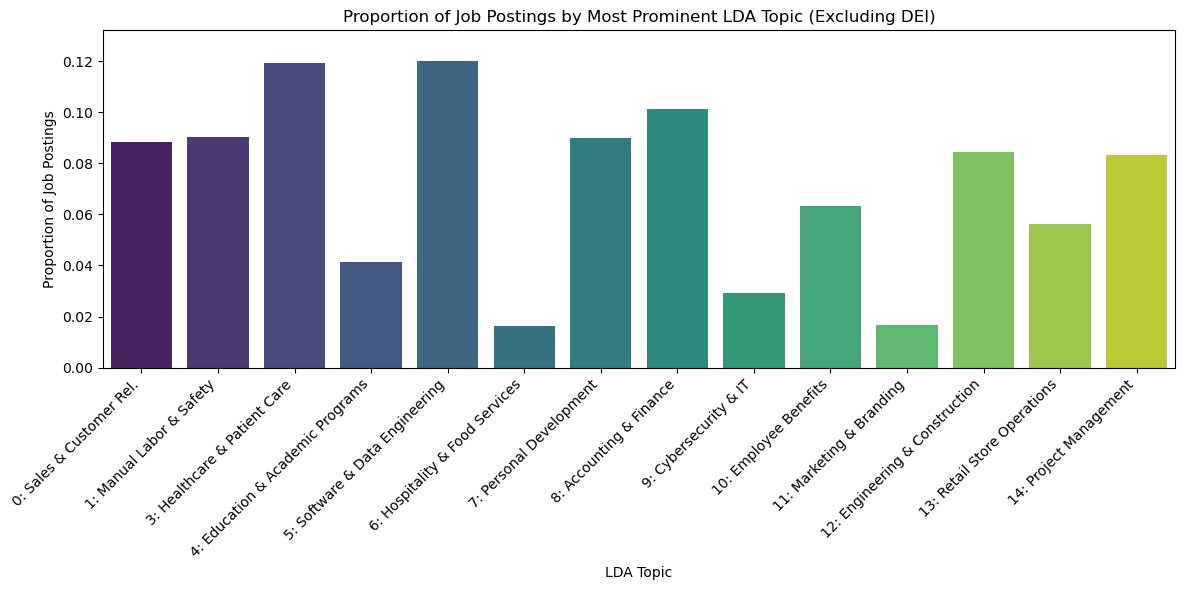

In [67]:
## --------------------------------------
## Step 1: Most common topic (only dominant ones) per posting 
## --------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Define topic labels excluding topic 2
topic_labels_filtered = {
    0: "0: Sales & Customer Rel.",
    1: "1: Manual Labor & Safety",
    3: "3: Healthcare & Patient Care",
    4: "4: Education & Academic Programs",
    5: "5: Software & Data Engineering",
    6: "6: Hospitality & Food Services",
    7: "7: Personal Development",
    8: "8: Accounting & Finance",
    9: "9: Cybersecurity & IT",
    10: "10: Employee Benefits",
    11: "11: Marketing & Branding",
    12: "12: Engineering & Construction",
    13: "13: Retail Store Operations",
    14: "14: Project Management"
}

# Filter out topic 2
jobs_filtered = jobs_df[jobs_df["lda_topic_1st"] != 2]

# Count topic frequencies and normalize to proportions
topic_counts = jobs_filtered["lda_topic_1st"].value_counts(normalize=True).sort_index()

# Create DataFrame for plotting
topic_df = topic_counts.reset_index()
topic_df.columns = ["topic_id", "proportion"]
topic_df["label"] = topic_df["topic_id"].map(topic_labels_filtered)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="label", y="proportion", data=topic_df, palette="viridis")

plt.title("Proportion of Job Postings by Most Prominent LDA Topic (Excluding DEI)")
plt.xlabel("LDA Topic")
plt.ylabel("Proportion of Job Postings")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, topic_df["proportion"].max() * 1.1)

plt.tight_layout()
plt.show()



/var/folders/61/4f46qg1x30s7x09xxzgv1qb40000gn/T/ipykernel_5633/614296587.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


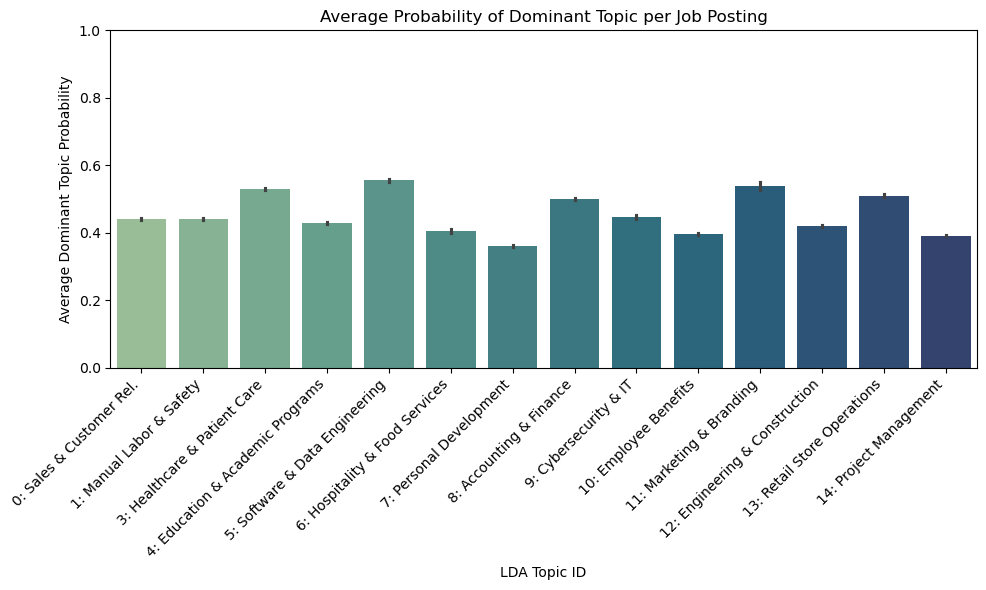

In [69]:
## --------------------------------------
## Step 2: Average topic probabilitys for the most dominant topics
## --------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    x="lda_topic_1st",
    y="lda_topic_1st_prob",
    data=jobs_filtered,
    estimator='mean',
    palette="crest"
)
plt.title("Average Probability of Dominant Topic per Job Posting")
plt.xlabel("LDA Topic ID")
plt.ylabel("Average Dominant Topic Probability")
plt.ylim(0, 1)

# Sort x labels to match actual plotted categories
sorted_topic_ids = sorted(jobs_filtered["lda_topic_1st"].dropna().unique())
plt.xticks(
    ticks=range(len(sorted_topic_ids)),
    labels=[topic_labels_filtered[tid] for tid in sorted_topic_ids],
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.show()

### SECTION 4.2: Evaluate the quality of topics 

Coherence measures how interpretable the topics are by quantifying the semantic similarity of the top words in each topic.

High coherence ⇒ Top words in each topic tend to co-occur in the corpus and form meaningful groups.

Low coherence ⇒ Top words are disjoint or random.

🧠 How to Interpret the Score
* Ranges from 0 to 1
* Rough guidelines:
    * 0.6–0.7: Moderate coherence
    * 0.7–0.85: Good
    * 0.85+: Very coherent topics (rare in messy text data)
      
⚠️ Caveat: High coherence doesn't always mean useful topics. Sometimes topics can be coherent but not informative for your goals (e.g., redundant or obvious topics like "equal opportunity").

In [77]:
## Evaluate Coherence (Quality of Topics)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(
    model=lda_model,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'
)

print("Coherence Score:", coherence_model.get_coherence())


Coherence Score: 0.5427369658838017


The current coherence score is moderate, but not ideal. I need to figure out how to improve this. 